# Check how to limit the maximum depth

# Method 1: Using grad from Midas

In [147]:
from diffusers import StableDiffusionPipeline, PNDMScheduler
import torch

pipe = StableDiffusionPipeline.from_pretrained(
    "/home/wukailu/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/39593d5650112b4cc580433f6b0435385882d819",
    torch_dtype=torch.float16).to("cuda")
pipe.enable_xformers_memory_efficient_attention()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/kailu/miniconda3/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [150]:
image_list = []
def print_callback(i, t, latent):
    print(i, t, latent.shape)
    # image_list.append(pipe.numpy_to_pil(pipe.decode_latents(latent.detach())))

def run(callback):
    generator = torch.Generator().manual_seed(233)
    ret = pipe(prompt="a bedroom", generator=generator, callback=callback, num_inference_steps=300)
    return ret.images[0]

In [151]:
image = run(print_callback)

  0%|          | 0/300 [00:00<?, ?it/s]

1 tensor(895, device='cuda:0') torch.Size([1, 4, 64, 64])
2 tensor(895, device='cuda:0') torch.Size([1, 4, 64, 64])
3 tensor(892, device='cuda:0') torch.Size([1, 4, 64, 64])
4 tensor(889, device='cuda:0') torch.Size([1, 4, 64, 64])
5 tensor(886, device='cuda:0') torch.Size([1, 4, 64, 64])
6 tensor(883, device='cuda:0') torch.Size([1, 4, 64, 64])
7 tensor(880, device='cuda:0') torch.Size([1, 4, 64, 64])
8 tensor(877, device='cuda:0') torch.Size([1, 4, 64, 64])
9 tensor(874, device='cuda:0') torch.Size([1, 4, 64, 64])
10 tensor(871, device='cuda:0') torch.Size([1, 4, 64, 64])
11 tensor(868, device='cuda:0') torch.Size([1, 4, 64, 64])
12 tensor(865, device='cuda:0') torch.Size([1, 4, 64, 64])
13 tensor(862, device='cuda:0') torch.Size([1, 4, 64, 64])
14 tensor(859, device='cuda:0') torch.Size([1, 4, 64, 64])
15 tensor(856, device='cuda:0') torch.Size([1, 4, 64, 64])
16 tensor(853, device='cuda:0') torch.Size([1, 4, 64, 64])
17 tensor(850, device='cuda:0') torch.Size([1, 4, 64, 64])
18 ten

In [ ]:
from IPython.display import display
for pil in image_list:
    display(pil[0])

In [152]:
import sys
sys.path.append("/home/wukailu/latent-nerf/src/ControlNet")
from annotator.midas import MidasDetector

midas = MidasDetector()

In [153]:
def decode_latents(ltt):
    latent = ltt * (1 / pipe.vae.config.scaling_factor)
    image = pipe.vae.decode(latent, return_dict=False)[0]
    image = (image / 2 + 0.5).clamp(0, 1)
    return image

In [157]:
hack_target = None
pipe.safety_checker = None

def midas_callback(i, t, latent):
    with torch.enable_grad():
        ltt: torch.Tensor = latent.detach()
        ltt = ltt.requires_grad_(True)
        image_depth = decode_latents(ltt).float()
        pred = midas.disp_with_grad(image_depth)
        target = torch.ones_like(pred) * (pred.mean().detach())
        global hack_target
        hack_target = pred.detach().cpu()
        loss_func = torch.nn.L1Loss()
        temp_t = 1.0
        loss = loss_func(pred/temp_t, target/temp_t)
        loss.backward()
        grad = ltt.grad * 1.0
        sqrt_one_minus_alpha_prod = (1 - pipe.scheduler.alphas_cumprod[t]) ** 0.5
        latent += grad * sqrt_one_minus_alpha_prod.to(grad)
    print(sqrt_one_minus_alpha_prod)
    print(latent.shape, latent.mean(), latent.std())
    print(grad.shape, grad.mean(), grad.std())

In [158]:
image = run(midas_callback)

  0%|          | 0/300 [00:00<?, ?it/s]

tensor(0.9925)
torch.Size([1, 4, 64, 64]) tensor(-0.0025, device='cuda:0', dtype=torch.float16) tensor(1.3125, device='cuda:0', dtype=torch.float16)
torch.Size([1, 4, 64, 64]) tensor(-0.0027, device='cuda:0', dtype=torch.float16) tensor(0.8623, device='cuda:0', dtype=torch.float16)
tensor(0.9925)
torch.Size([1, 4, 64, 64]) tensor(-0.0052, device='cuda:0', dtype=torch.float16) tensor(1.4307, device='cuda:0', dtype=torch.float16)
torch.Size([1, 4, 64, 64]) tensor(-0.0028, device='cuda:0', dtype=torch.float16) tensor(0.5889, device='cuda:0', dtype=torch.float16)
tensor(0.9923)
torch.Size([1, 4, 64, 64]) tensor(-0.0151, device='cuda:0', dtype=torch.float16) tensor(1.5752, device='cuda:0', dtype=torch.float16)
torch.Size([1, 4, 64, 64]) tensor(-0.0099, device='cuda:0', dtype=torch.float16) tensor(0.6709, device='cuda:0', dtype=torch.float16)
tensor(0.9920)
torch.Size([1, 4, 64, 64]) tensor(-0.0153, device='cuda:0', dtype=torch.float16) tensor(1.5918, device='cuda:0', dtype=torch.float16)
to

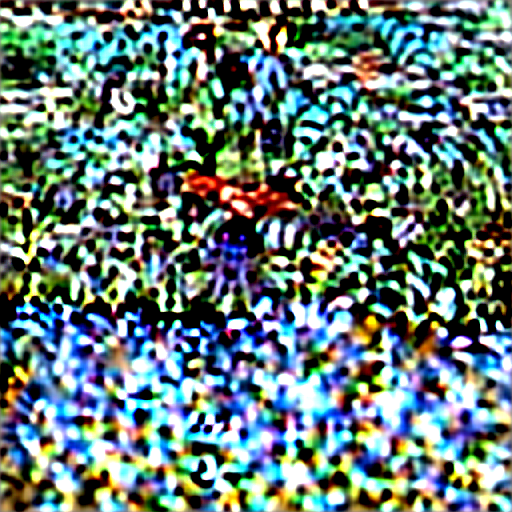

In [159]:
image

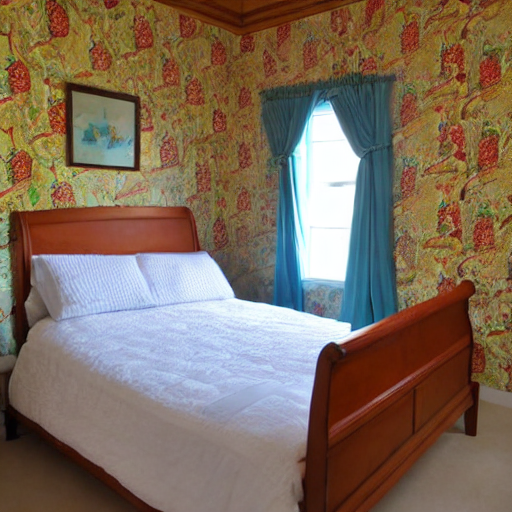

In [88]:
image

In [94]:
def pred_disp(input_image) -> torch.FloatTensor:
    from annotator.util import resize_image, HWC3
    with torch.no_grad():
        input_image = HWC3(input_image)
        detected_map: torch.FloatTensor = midas(input_image)
    return detected_map[0]

In [99]:
import numpy as np
disp = pred_disp(np.array(image))

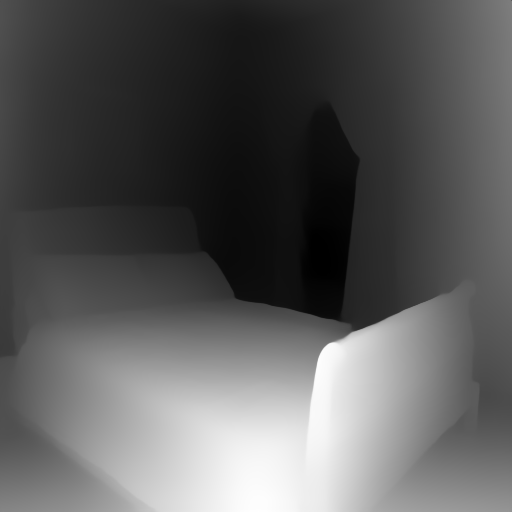

In [100]:
from PIL import Image
Image.fromarray(disp)

# Method 2: using grad from a ReLU network between depth and target

In [ ]:
mean_std = torch.tensor([
    (-0.24595006, 0.54566), # R
    (-0.13202806, 0.55846), # G
    (-0.02775778, 0.57430), # B
    ( 1.72314970, 0.99023), # D
])

In [ ]:

from torch import nn
from ldm.modules.diffusionmodules.openaimodel import UNetModel
def get_unet():
    unet = UNetModel(image_size=IMG_SIZE,
                     in_channels=8, out_channels=4,
                     model_channels=128, # the base channel (smallest)
                     channel_mult=[1, 2, 3, 3, 4, 4],
                     num_res_blocks=2,
                     num_head_channels=32,
                     # down 1     2      4          8          16         32
                     # res  128   64     32         16         8          4
                     # chan 128   256    384        384        512        512
                     # type conv  conv   conv+attn  conv+attn  conv+attn  conv+attn
                     attention_resolutions=[4, 8, 16, 32],
                     use_checkpoint=True,
                     use_fp16=FP16_MODE,
                    )
    # use num_groups==1, to avoid color shift problem
    for name, module in unet.named_modules():
        if isinstance(module, nn.GroupNorm):
            module.num_groups = 1
            print(f"convert GN to LN for module: {name}")
    return unet

class Model(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.unet = get_unet()
        # dummy params
        self.no_pixel = nn.Parameter(torch.zeros(4))

    def forward(self, rgbd, cam, t):
        """
        Args:
            rgbd.shape == (B, N, C, H, W)
            cam (tuple): include intrinsic and pose matrices, shape == (B, N, 3, 3) / (B, N, 3, 4)

            NOTE
            only curr view (i.e. rgbd[:, -1]) is noised
            N == num of views (prev + curr)
            invalid depth is zero, then will be trimmed
        """
        B, N = rgbd.shape[:2]
        assert N >= 2, "at least one previous view is provided. if there is no previous views, please provide zero"
        camint, camext = cam
        rgbd_render = self.render_views(
               rgbd[:, :-1],
            (camint[:, :-1], camext[:, :-1]),
            (camint[:,  -1], camext[:,  -1]),
        ).rgbd # (B, C, H, W)
        #
        unet_in = torch.cat([rgbd_render, rgbd[:, -1]], dim=1) # (B, 4 + 4, H, W)
        pred = self.unet(unet_in, t) # (B, C, H, W)
        return pred

model = Model()

@torch.no_grad()
def sampling_forward_fn(self, rgbd, t): # forward func only for classifier-free sampling
    t = t.reshape([1])
    # forward
    with torch.cuda.amp.autocast(enabled=FP16_MODE):
        if guidance == 0.0:
            rgbd[:, :4, ...] = model.no_pixel[None, :, None, None]
            pred = model.unet(rgbd, t)
        elif guidance == 1.0:
            pred = model.unet(rgbd, t)
        else:
            pred_cond   = model.unet(rgbd, t)
            rgbd[:, :4, ...] = model.no_pixel[None, :, None, None]
            pred_uncond = model.unet(rgbd, t)
            pred = pred_uncond + guidance * (pred_cond - pred_uncond)
    return pred.float()

# Method 3: extend method 2 to latent diffusion